<a href="https://colab.research.google.com/github/ipavlopoulos/paremia/blob/main/spatial_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spatial Analysis: Text Classification, Clustering, and Regression

* Using a collection of proverbs from the [Hellenic Folklore Research Centre](http://www.kentrolaografias.gr/) of the Academy of Athens.
* Using [Folium](https://pypi.org/project/folium/), [Geopy](https://geopy.readthedocs.io/en/stable/), and [scikit-learn](https://scikit-learn.org/stable/) algorithms for hierarchical clustering, classification and regression.

---


In [ ]:
%%capture
!pip install geopandas
!pip install geopy
!pip install folium
!pip install gdown
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium
from tqdm.notebook import tqdm
from folium import Choropleth, Circle, CircleMarker, Marker
from folium.plugins import MarkerCluster
from collections import Counter
import nltk; nltk.download('stopwords')
import matplotlib.pyplot as plt

## Loading the data

In [ ]:
proverbs = pd.read_csv("https://raw.githubusercontent.com/ipavlopoulos/paremia/main/input/proverbs.csv", index_col=0)
proverbs.shape

(134493, 4)

In [ ]:
proverbs.sample(3)

,text,place,uri,collector
63325,Η τσιγγάνα το ντρουβά της κε' θωρεί το,"Μικρά Ασία, Σινώπη",http://hdl.handle.net/20.500.11853/160968,"Λιουδάκη, Μαρία"
32574,"Ναν τα λε, μα ναν και δίκηα!",Επτάνησος,http://hdl.handle.net/20.500.11853/275887,"Καββαδίας, Γεώργιος"
34777,Πού σκοινιά ναν τονε δέσουν!,Επτάνησος,http://hdl.handle.net/20.500.11853/175330,"Καββαδίας, Γεώργιος"


* Few proverbs comrpise definitions, removing them

In [ ]:
proverbs[proverbs.text.str.contains("=")].sample().text.item()

"Κατά το παλληκάρι είναι και τ' άρματα = Qual quaina, tal coltello"

In [ ]:
proverbs = proverbs[~proverbs.text.str.contains("=")]
proverbs.shape

(134106, 4)

* Also, duplicates exist.
* Counting them by measuring the rows of the initial dataframe, then subtracting the unique rows. 

In [ ]:
print(f"{proverbs.shape[0] - proverbs.drop_duplicates().shape[0]} duplicates")

13875 duplicates


* Climbing up to the highest-level information per location labelled 
* In 'Κέρκυρα, Οθωνοί', for example, we only keep the first part of the term, using `split` to tokenise.

In [ ]:
proverbs["area"] = proverbs.place.map(lambda x: x.split(",")[0])
proverbs.sample(3)

,text,place,uri,collector,area
2939,Τώρα στα ξημερώματα γεια σου κουμπάρε Γιάννη,Κύθνος,http://hdl.handle.net/20.500.11853/289582,"Βάλληνδας, Α.",Κύθνος
132803,Άνοιξε η ποριά; Άνοιξε για όλους,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/249142,anonymous,Άδηλου τόπου
51157,"Όψιμη παντρειά, όψιμη αρμάνια!","Αχαΐα, Πάτρα",http://hdl.handle.net/20.500.11853/253747,"Κορύλλος, Χρήστος Π.",Αχαΐα


* One more observation regards proverbs with no information about their location 


In [ ]:
len(proverbs[proverbs.area=='Άδηλου τόπου'].text.unique())

3698

# Geolocating

* There are 134 unique broad areas registered in the collection

In [ ]:
locations = proverbs.area.unique()
len(locations)

134

* We will find the geographical coordinates of each one
* Using [geopy](https://geopy.readthedocs.io/en/stable/#), which is a Python client for geocoding web services, locating the coordinates (e.g., of addresses, cities, countries) across the globe.



In [ ]:
from geopy.geocoders import Nominatim # import the library
geolocator = Nominatim(user_agent="paremia") # initialise it

* We want to geocode each location in our dataframe
* Adding the country's name in the query improves the accuracy
* But geolocation still doesn't work for all places, printing them to fix with hardcoding  

In [ ]:
geolocs = {}
for loc in locations:
    # Avoiding polysemy by including "Greece" in the query
    location = geolocator.geocode(loc+ ", Ελλάδα") 
    if location:
        geolocs[loc] = {"lat":location.latitude, "lon":location.longitude}
    else:
        print (loc)

Άδηλου τόπου
Φθιώτιδα
Αδριανούπολη
Δυτική Μάνη
Καππαδοκία
Δαρδανέλλια (Ελλήσποντος)
Αλβανία
Φωκίδα
Ημαθία
Βοιωτία
Αερόπολη
Τριφυλία
Μπλάτση
Ανατολική Κρήτη
Ανατολική Θράκη
Ανδρίτσαινα Ολυμπίου
Δυτική Κρήτη
Στερεά Ελλάδα
Ναυπακτία
Δωδεκάνησα
Λεπενού Αιτωλοακαρνανίας (επαρχία Βάλτου)


* Fixing places which were problematic
* Cyprus was also ambiguous and mislocated

In [ ]:
# fixing some by hand
location = geolocator.geocode("Cyprus")
geolocs["Κύπρος"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Siteia")
geolocs["Ανατολική Κρήτη"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Chania")
geolocs["Δυτική Κρήτη"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Nafpaktia")
geolocs["Ναυπακτία"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Lepenou")
geolocs["Λεπενού Αιτωλοακαρνανίας (επαρχία Βάλτου)"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Cappadocia")
geolocs["Καππαδοκία"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Imathia")
geolocs["Ημαθία"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Boeotia")
geolocs["Βοιωτία"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Edirne")
geolocs["Ανατολική Θράκη"] = {"lat":location.latitude, "lon":location.longitude}
geolocs["Αδριανούπολη"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Phthiotis")
geolocs["Φθιώτιδα"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Andritsaina")
geolocs["Ανδρίτσαινα Ολυμπίου"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Dardanelles Strait")
geolocs["Δαρδανέλλια (Ελλήσποντος)"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Central Greece")
geolocs["Στερεά Ελλάδα"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Areopoli")
geolocs["Αερόπολη"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Trifylia")
geolocs["Τριφυλία"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("Phocis")
geolocs["Φωκίδα"] = {"lat":location.latitude, "lon":location.longitude}
location = geolocator.geocode("West Mani")
geolocs["Δυτική Μάνη"] = {"lat":location.latitude, "lon":location.longitude}

* Saving this (as a dataframe) can save us time in future runs

In [ ]:
pd.DataFrame(geolocs).to_csv("geolocs.csv", index=False) # passing in a dataframe
geolocs = pd.read_csv("geolocs.csv") 
geolocs.index=["lat", "lon"]
geolocs

,Κρήτη,Σίφνος,Σέρρες,Πήλιο,Ήπειρος,Λευκάδα,Αχαΐα,Εύβοια,Μακεδονία,Κύπρος,...,Ανατολική Θράκη,Αδριανούπολη,Φθιώτιδα,Ανδρίτσαινα Ολυμπίου,Δαρδανέλλια (Ελλήσποντος),Στερεά Ελλάδα,Αερόπολη,Τριφυλία,Φωκίδα,Δυτική Μάνη
lat,35.308495,36.971401,41.091071,39.365088,37.998253,38.706573,38.069275,38.494172,40.686024,34.982302,...,41.675933,41.675933,38.88734,37.483836,40.337606,38.562460,36.665918,37.195013,38.499868,22.581762
lon,24.463342,24.708110,23.549803,23.135561,23.737867,20.641709,21.872730,23.911084,23.693434,33.145128,...,26.558722,26.558722,22.36803,21.905533,26.640821,23.161853,22.381635,21.703732,22.248780,88.399181


In [ ]:
# turning it into a dict, our initial selection
geolocs = geolocs.to_dict()

* Now, updating the corpus with the mined information

In [ ]:
proverbs['lat'] = proverbs.area.map(lambda x: geolocs[x]["lat"] if x in geolocs else None)
proverbs['lon'] = proverbs.area.map(lambda x: geolocs[x]["lon"] if x in geolocs else None)
proverbs[proverbs.lon.notna()].shape

(125222, 7)

# The anonymous collector
* Not all proverbs were collected by named individuals

In [ ]:
anonymous = proverbs[proverbs.collector=="anonymous"]
named = proverbs[proverbs.collector!="anonymous"]
print(f'{anonymous.shape[0]} proverbs from the anonymous collectors')

14835 proverbs from the anonymous collectors


# Duplicates
* Focusing on proverbs shared among locations
* Using ones by named collectors
* While the areas of the duplicates collected by anonymous individuals are not many

In [ ]:
print(f'Only {named.duplicated().sum()} duplicate proverbs from named collectors')
print(f'while {anonymous.duplicated().sum()} are from the anonymous collector')

Only 29 duplicate proverbs from named collectors
while 13846 are from the anonymous collector


* The duplicates from the named collectors concern only three locations

In [ ]:
named[named.duplicated()].area.unique()

array(['Κρήτη', 'Μικρά Ασία', 'Ήπειρος'], dtype=object)

* Grouping by text, to form duplicates using items by named collectors

In [ ]:
grouping = named[named.lat.notna()&named.lon.notna()].groupby("text")
duplicates = pd.DataFrame({"place": grouping.place.apply(set)})
duplicates["place_num"] = duplicates.place.apply(len)
duplicates.sort_values(by="place_num", ascending=False)[:3]

,place,place_num
text,,
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει,"{Δαρδανέλλια (Ελλήσποντος), Ιωάννινα, Κοζάνη, ...",45
"Ανεμομαζώματα, διαβολοσκορπίσματα","{Δαρδανέλλια (Ελλήσποντος), Νάξος, Απείρανθος,...",28
Θεωρία επισκόπου και καρδιά μυλωνά,"{Δαρδανέλλια (Ελλήσποντος), Ιωάννινα, Φιλιππού...",27


* Finding the broader location

In [ ]:
duplicates["area"] = duplicates.place.map(lambda x: {i.split(",")[0] for i in x})
duplicates["area_num"] = duplicates.area.apply(len)
duplicates.sort_values(by="area_num", ascending=False)[:3]

,place,place_num,area,area_num
text,,,,
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει,"{Δαρδανέλλια (Ελλήσποντος), Ιωάννινα, Κοζάνη, ...",45,"{Δαρδανέλλια (Ελλήσποντος), Ιωάννινα, Αρκαδία,...",23
Στου κουφού την πόρτα όσο θέλεις βρόντα,"{Κοζάνη, Μηλιά, Πέλλα, Γιαννιτσά, Αραβησσός, Φ...",26,"{Αρκαδία, Ιωάννινα, Φιλιππούπολη, Άνδρος, Θράκ...",20
"Ανεμομαζώματα, διαβολοσκορπίσματα","{Δαρδανέλλια (Ελλήσποντος), Νάξος, Απείρανθος,...",28,"{Δαρδανέλλια (Ελλήσποντος), Αρκαδία, Θράκη, Ήπ...",18


In [ ]:
print(f"Out of the {duplicates.shape[0]} unique texts,", 
      f"{duplicates[duplicates.area_num>1].shape[0]} exist in multiple areas")

Out of the 105612 unique texts, 3204 exist in multiple areas


* Focus on proverbs common across broad areas

In [ ]:
duplicates = duplicates[duplicates.area_num>1]

* Adding the geographical coordinates in the duplicates.
* We want a list per proverb, given that we have one to many as our mapping

In [ ]:
coordinates = duplicates.area.map(lambda x: [(geolocs[loc]["lat"], geolocs[loc]["lon"]) 
                                                        for loc in x if loc in geolocs and loc!="Άδηλου τόπου"])
duplicates.insert(4, 'latlon', coordinates) 
duplicates.sample()

,place,place_num,area,area_num,latlon
text,,,,,
"Ό,τι βρεξει στο βουνό στον κάμπο κατεβάζει","{Θεσσαλία, Λακωνία}",2,"{Θεσσαλία, Λακωνία}",2,"[(39.5594194, 21.6848495), (36.76027945, 22.79..."


In [ ]:
# saving
duplicates.to_pickle("duplicates_geolocated.csv")

* Visualising the dataframe
* We will use [Folium](https://python-visualization.github.io/folium), which is based on [leaflet](https://leafletjs.com/), an open-source JavaScript library for mobile-friendly interactive maps. 
* Note that outliers exist: Chiesa della Madona delle Neve

In [ ]:
m = folium.Map(location=[39.0742, 21.8243], zoom_start=6)
for i in range(duplicates.shape[0]):
    loc = duplicates.iloc[i].latlon
    folium.PolyLine(loc, color='red', weight=1, opacity=0.1).add_to(m)
m.save("duplicates.html"); m

* Computing the number of areas sharing proverbs with crowdy Athens


In [ ]:
area = 'Αθήνα'
print(f"Branching factor of {area}: {len(duplicates[duplicates.area.apply(lambda x: 'Αθήνα' in x)].area.explode().unique())}")

Branching factor of Αθήνα: 20


# Single-placed proverbs

In [ ]:
# keeping single-placed proverbs
proverbs_sp = named[~named.text.duplicated(keep=False)]
proverbs_sp.sample(3)

,text,place,uri,collector,area,lat,lon
74067,"Άνθρωπος πολύβουλος, Θεός ο βουληκόπος",Ήπειρος,http://hdl.handle.net/20.500.11853/256919,"Μανούσος, Αντώνιος",Ήπειρος,37.998253,23.737867
45455,Σαράdα λάκ' ς ιλιές,"Ήπειρος, Δολιανά",http://hdl.handle.net/20.500.11853/170459,"Κοντοπάνος, Α.",Ήπειρος,37.998253,23.737867
16352,Ο Χριστός ευλόησε bρώτα τα 'ενάκια dου,"Νάξος, Απείρανθος",http://hdl.handle.net/20.500.11853/188819,"Ζευγώλη – Γλέζου, Διαλεχτή",Νάξος,37.060010,25.470757


* Keeping aside single-placed proberbs from an unknown place
* Working with the rest


In [ ]:
unlocated = "Άδηλου τόπου"
proverbs_sp_unk = proverbs_sp[proverbs_sp.place==unlocated]
print(f'{proverbs_sp_unk.shape[0]} proverbs from one place, whose name is not known.')
proverbs_sp_unk.sample(3)

2755 proverbs from one place, whose name is not known.


,text,place,uri,collector,area,lat,lon
83956,Εκέρδησε το κουραδόκαστρο,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/208408,"Νεστορίδης, Κ.",Άδηλου τόπου,NaN,NaN
53960,Ο πτωχός δεν είδε κάστρο κ' είδε φούρνον κ' ετ...,Άδηλου τόπου,http://hdl.handle.net/20.500.11853/150442,"Κουμανούδης, Π.",Άδηλου τόπου,NaN,NaN
84186,Ζωή σκύλινη (περνά),Άδηλου τόπου,http://hdl.handle.net/20.500.11853/175861,"Νεστορίδης, Κ.",Άδηλου τόπου,NaN,NaN


In [ ]:
proverbs_sp = proverbs_sp[proverbs_sp.place!=unlocated]
print(f'{proverbs_sp.shape[0]} proverbs from one place with known place name')

98124 proverbs from one place with known place name


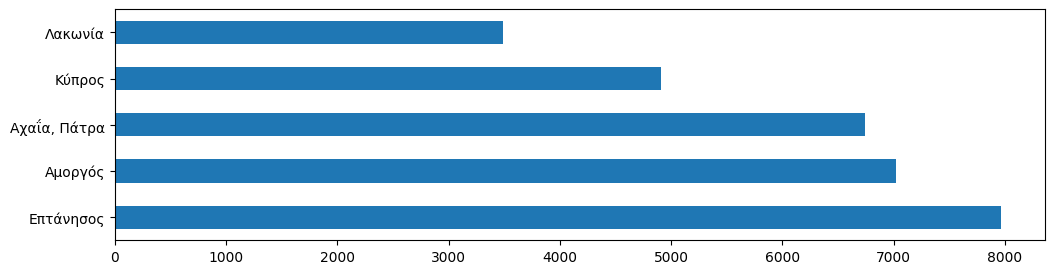

In [ ]:
proverbs_sp.place.value_counts()[:5].plot.barh(figsize=(12,3));

* Visualising the places along with the number of proverbs collected there

In [ ]:
freq_places = proverbs_sp.place.value_counts()[:20]
m = folium.Map(location=[39.0742, 21.8243], zoom_start=5)
for i in range(10):
    freq = freq_places.iloc[i]
    place = freq_places.index[i].split(",")[0]
    loc = geolocs[place]
    folium.CircleMarker((loc["lat"], loc["lon"]), 
                  radius=freq/500,
                  popup=f"{freq}",
                  color="#3186cc",
                  fill=True,
                  fill_color="#3186cc").add_to(m)
m.save('frequent_places.html'); m

* Next, we work with ones that own 1,000 or more proverbs, allowing sampling without class imbalance issues

In [ ]:
group_level = "area"
placed = proverbs_sp.groupby(group_level)
placed_pd = pd.DataFrame({"text": placed.text.apply(list)})
placed_pd["length"] = placed_pd.text.apply(len)
print(f"Out of the {placed_pd.shape[0]} places, {placed_pd[placed_pd.length>1000].shape[0]} own 1000 proverbs or more.")

Out of the 129 places, 23 own 1000 proverbs or more.


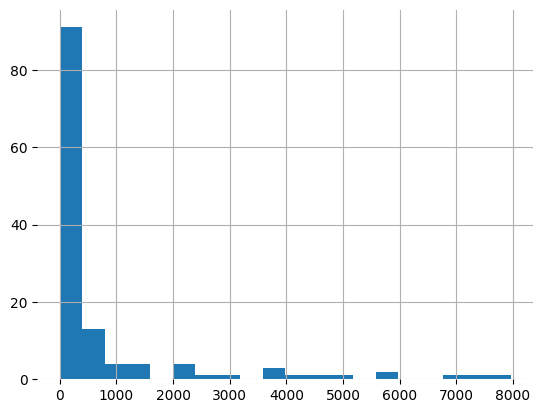

In [ ]:
placed_pd.length.hist(bins=20);
sns.despine(left=True, bottom=True)

* The proverbs from places reported at least 1,000 times are more than 80,000


In [ ]:
common_places = placed_pd[placed_pd.length>1000].index
# filtering texts found on these places
common_sayings = proverbs_sp[proverbs_sp[group_level].isin(common_places)]
print(f"Found {common_sayings.shape[0]} proverbs from {len(common_places)} places")

Found 80893 proverbs from 23 places


* Removing proverbs with unknown (invalid?) characters

In [ ]:
stopchars = {'$', '*', '+', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'G', 'H', 'I', 'N', 'O', 'P', 'S', 'T', 'W', '[', ']', 'a','b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'y', 'z', 'ä', '\ufeff'}
common_sayings_norm = common_sayings[~common_sayings.text.apply(lambda x: len(set(x).intersection(stopchars))>0)]

* Creating a location-balanced corpus


In [ ]:
balanced_corpus = pd.concat([common_sayings_norm[common_sayings_norm.area==a].sample(500) for a in common_places])
balanced_corpus.shape

(11500, 7)

## Location-based TF * IDF
* For each place, we compute character n-gram frequencies (TF).
* Terms infrequent across all places are more important (IDF). 

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
long_texts = [" \n ".join(balanced_corpus[balanced_corpus.area==a].text.values) for a in common_places]
vect = TfidfVectorizer(ngram_range=(2,5), analyzer="char", max_df=0.5, min_df=5, lowercase=True)
X = vect.fit_transform(long_texts)

In [ ]:
# computing the TFIDF per place
geotfidf = pd.DataFrame(columns = common_places, index=vect.get_feature_names_out())
for i, a in enumerate(common_places):
    geotfidf[a] = np.array(X[i].sum(0))[0]

* Sorting the frequencies per place, gives characteristic n-grams; i.e., frequent locally yet infrequent globally.

In [ ]:
geotfidf.sort_values(by="Κύπρος", ascending=False).head(3)

area,Ήπειρος,Αιτωλία,Αμοργός,Ανατολική Θράκη,Αρκαδία,Αχαΐα,Επτάνησος,Εύβοια,Θεσπρωτία,Θράκη,...,Κρήτη,Κύπρος,Λέσβος,Λακωνία,Μακεδονία,Μικρά Ασία,Νάξος,Πόντος,Ρόδος,Σκύρος
τζ',0.0,0.0,0.0,0.0,0.0,0.0,0.007243,0.0,0.0,0.009608,...,0.007581,0.333452,0.0,0.0,0.0,0.0,0.008011,0.0,0.0,0.000000
τζ',0.0,0.0,0.0,0.0,0.0,0.0,0.007243,0.0,0.0,0.009608,...,0.007581,0.333452,0.0,0.0,0.0,0.0,0.008011,0.0,0.0,0.000000
τζ',0.0,0.0,0.0,0.0,0.0,0.0,0.006775,0.0,0.0,0.008988,...,0.007091,0.331611,0.0,0.0,0.0,0.0,0.007493,0.0,0.0,0.005011


* Computing a lexicon with the terms with the highest TFIDF value per area

In [ ]:
area_ngrams = {a:list(geotfidf.sort_values(by=a, ascending=False)[a].head(3).index) for a in common_places}

* Locating the important terms on the map

In [ ]:
m = folium.Map(location=[39.0742, 21.8243], zoom_start=5)
for a in area_ngrams:
    ngrams = ", ".join(area_ngrams[a])
    loc = geolocs[a]
    folium.Circle([loc["lat"], loc["lon"]], 20000, fill=True).add_child(folium.Popup(ngrams)).add_to(m)
m.save('frequent_ngrams.html'); m

In [ ]:
geotfidf.to_csv("geotfidf.csv")

In [ ]:
pd.DataFrame(area_ngrams)

,Ήπειρος,Αιτωλία,Αμοργός,Ανατολική Θράκη,Αρκαδία,Αχαΐα,Επτάνησος,Εύβοια,Θεσπρωτία,Θράκη,...,Κρήτη,Κύπρος,Λέσβος,Λακωνία,Μακεδονία,Μικρά Ασία,Νάξος,Πόντος,Ρόδος,Σκύρος
0,ου,ου,μηδ,τ' αβ,βει,! ο,ναν,σαί,ο),πε,...,τση,τζ',τσι,ςτ,ου,κη,'ι,ν ατ,θθ,τσαί
1,κι τ,τς,μηδ,πείσ,λιθ,! ο,α δε,τσαί,ο),πε τ,...,τση,τζ',νιρ,ςτ,κι τ,ννει,τση,άτ,κάμν,τσαί
2,ά μας,τς,μηδέ,μάξ,λιθά,! το,α δ,τσαί,(το,τς,...,τση,τζ',νιρ,νούρι,ιτι,νιν,τση,ν κ',κάμν,σαί


# Authorship analysis
* Training one language model per area, by sampling proverbs of that area



In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(balanced_corpus, test_size=0.05, random_state=2023)
train, dev = train_test_split(train, test_size=test.shape[0], random_state=2023)

In [ ]:
# INFO: robustness at stake
#!git clone https://github.com/ipavlopoulos/lm
from lm.markov.models import LM
from lm.neural.models import 
models = {}
for area in train.area.unique():
    texts = train[train.area==area].text.values
    models[area] = LM(gram="CHAR").train(" \n ".join(texts))
    
def ling_dist(proverb, models=models):
    entropy = {loc:[models[loc].ppl(proverb)] for loc in models.keys()}
    likelier = min(entropy, key=entropy.get) 
    return likelier, pd.DataFrame(entropy)

loc, dists = ling_dist('κακό χωριό τα λίγα σπίτια')
dists.sort_values(by=0, ascending=True, axis=1)

,Επτάνησος,Κεφαλληνία,Ανατολική Θράκη,Κρήτη,Θράκη,Ήπειρος,Αρκαδία,Εύβοια,Λακωνία,Ρόδος,...,Ιωάννινα,Αιτωλία,Σκύρος,Νάξος,Θεσπρωτία,Μικρά Ασία,Αμοργός,Λέσβος,Κύπρος,Πόντος
0,6.787911,8.754034,12.330201,12.709717,16.117201,16.697882,17.169054,17.864446,19.275589,20.279493,...,24.297658,24.423565,25.395035,25.457439,26.676815,34.57072,37.934895,41.217137,42.812059,75.295531


* Evaluating on unseen proverbs

In [ ]:
from sklearn.metrics import *
predictions = test.text.apply(lambda x: ling_dist(x, models=models)[0])
print(classification_report(test.area.values, predictions, zero_division=0))

                 precision    recall  f1-score   support

        Ήπειρος       0.22      0.26      0.24        23
        Αιτωλία       0.38      0.21      0.27        24
        Αμοργός       0.23      0.14      0.17        22
Ανατολική Θράκη       0.10      0.12      0.11        24
        Αρκαδία       0.13      0.19      0.15        31
          Αχαΐα       0.15      0.12      0.14        32
      Επτάνησος       0.24      0.26      0.25        23
         Εύβοια       0.10      0.20      0.13        20
      Θεσπρωτία       0.12      0.18      0.15        22
          Θράκη       0.17      0.08      0.11        25
       Ιωάννινα       0.18      0.21      0.19        29
       Κάρπαθος       0.41      0.39      0.40        28
     Κεφαλληνία       0.12      0.15      0.13        27
          Κρήτη       0.23      0.17      0.19        30
         Κύπρος       0.70      0.58      0.64        24
         Λέσβος       0.38      0.33      0.36        24
        Λακωνία       0.21    

* The confusion matrix can inform us about the confusion in the predictions

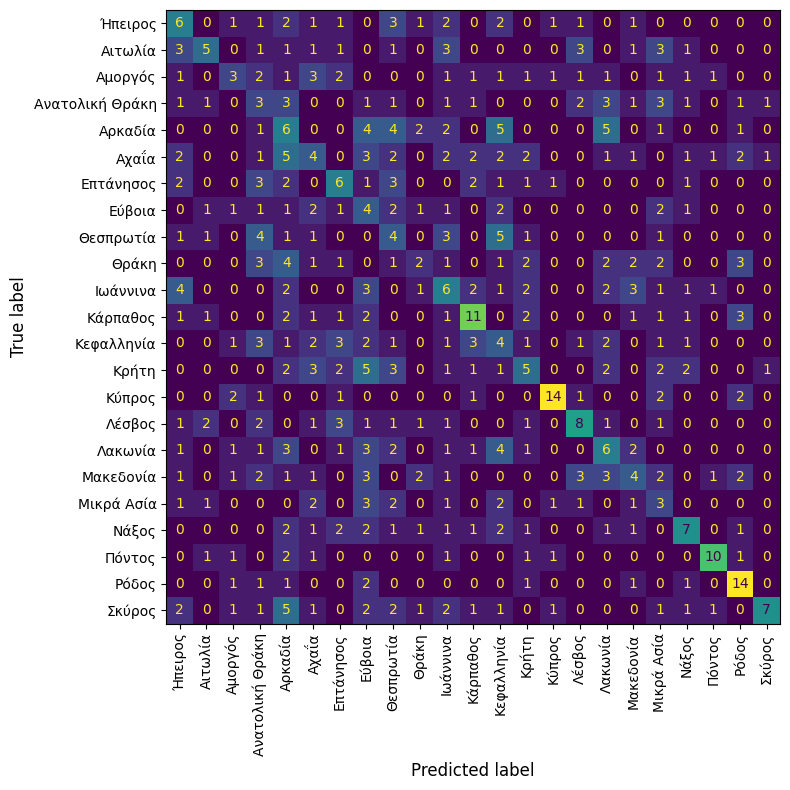

In [ ]:
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams["axes.labelsize"] = 12
cm = ConfusionMatrixDisplay.from_predictions(test.area.values, predictions, xticks_rotation='vertical', colorbar=False);
cm.figure_.tight_layout()
cm.figure_.savefig('authorship_confusion.pdf', format="PDF", dpi=300)

# Text spatial classification
* Trying with a standard text classifier improves slightly the accuracy but similar findings are reported

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier

Learning a location classifier on top of character n-grams

In [ ]:
# text classification flat
vect = TfidfVectorizer(ngram_range=(2,5), analyzer="char", max_df=0.5, min_df=5, lowercase=True)
locator = Pipeline([('vect', vect), ('clf', LogisticRegression())])
locator.fit(train.text.values, train.area.values)
txt_preds = locator.predict(test.text.values)
print(classification_report(test.area.values, txt_preds, zero_division=0))

                 precision    recall  f1-score   support

        Ήπειρος       0.08      0.04      0.06        23
        Αιτωλία       0.22      0.25      0.24        24
        Αμοργός       0.23      0.32      0.27        22
Ανατολική Θράκη       0.10      0.12      0.11        24
        Αρκαδία       0.16      0.10      0.12        31
          Αχαΐα       0.50      0.34      0.41        32
      Επτάνησος       0.16      0.22      0.18        23
         Εύβοια       0.14      0.10      0.12        20
      Θεσπρωτία       0.17      0.23      0.19        22
          Θράκη       0.12      0.12      0.12        25
       Ιωάννινα       0.22      0.21      0.21        29
       Κάρπαθος       0.65      0.54      0.59        28
     Κεφαλληνία       0.16      0.15      0.15        27
          Κρήτη       0.32      0.20      0.24        30
         Κύπρος       0.67      0.75      0.71        24
         Λέσβος       0.32      0.46      0.38        24
        Λακωνία       0.27    

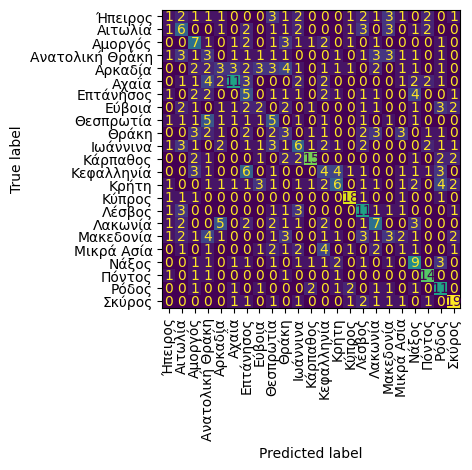

In [ ]:
cm = ConfusionMatrixDisplay.from_estimator(locator, test.text.values, test.area.values, xticks_rotation='vertical', colorbar=False);
cm.figure_.tight_layout()

# Classifying multi-located proverbs

* Such a classifier can give an estimate about the origins of proverbs multiply located  

In [ ]:
duplicated_predicted_pd = duplicates[duplicates.area_num>1]
duplicated_predicted_pd.insert(4, "prediction", locator.predict(duplicated_predicted_pd.index.values))
duplicated_predicted_pd.insert(5, "confidence", probs.max(1))
probs = locator.predict_proba(duplicated_predicted_pd.index.values)
# duplicated_predicted_pd.reset_index().to_excel("sayings_duplicated_located.xlsx", index=False)
duplicated_predicted_pd.sort_values(by="confidence", ascending=False).head(20)

,place,place_num,area,area_num,prediction,confidence,latlon
text,,,,,,,
Όπου γάιδαρος κι αυτός σαμάρι,"{Ιωάννινα, Αρκαδία, Γορτυνία}",2,"{Ιωάννινα, Αρκαδία}",2,Αιτωλία,0.486985,"[(39.6639818, 20.8522784), (38.0368583, 23.668..."
Μασά τα λόγια του,"{Αμοργός, Θράκη, Αίνος}",2,"{Θράκη, Αμοργός}",2,Λέσβος,0.450911,"[(40.8464241, 25.8759377), (36.85252415, 25.89..."
Αυτός είνι κατέβα να φάμι,"{Λέσβος, Πλωμάρι, Σάμος, Μαραθόκαμπος}",2,"{Σάμος, Λέσβος}",2,Αιτωλία,0.427233,"[(37.72461615, 26.81929189110984), (39.1758418..."
Αυτός είναι ανεμόμυλος,"{Μικρά Ασία, Κυδωνία, Ανατολική Θράκη, Αχαΐα, ...",3,"{Αχαΐα, Μικρά Ασία, Ανατολική Θράκη}",3,Αχαΐα,0.416851,"[(38.0692748, 21.87273042232539), (38.1846366,..."
Αυτός είναι διάβολος με τα κέρατα,"{Μικρά Ασία, Κύζικος, Πάνορμος, Αχαΐα, Πάτρα}",2,"{Αχαΐα, Μικρά Ασία}",2,Αχαΐα,0.415118,"[(38.0692748, 21.87273042232539), (38.1846366,..."
Αυτός είναι μη μου άπτου,"{Αμοργός, Ιωάννινα, Νεγάδες}",2,"{Ιωάννινα, Αμοργός}",2,Αχαΐα,0.399693,"[(39.6639818, 20.8522784), (36.85252415, 25.89..."
Πίσου είνι του πουτήρ' μι τ' ρίγαν',"{Αιτωλία, Αμβρακιά, Αρκαδία, Γορτυνία, Λάστα}",2,"{Αιτωλία, Αρκαδία}",2,Αιτωλία,0.374155,"[(37.4204248, 24.9479564), (38.0368583, 23.668..."
Όσα ξέρει ο νοικοκύρης δεν τα ξέρει ο μουσαφίρης,"{Κεφαλληνία, Λειβαθώ, Θεσπρωτία, Παραμυθιά, Κο...",3,"{Θεσπρωτία, Κοζάνη, Κεφαλληνία}",3,Επτάνησος,0.366111,"[(39.54401235, 20.308355368968883), (40.300725..."
Τα λόγια κουμέρκι δεν έχουν,"{Θεσσαλία, Λακωνία}",2,"{Θεσσαλία, Λακωνία}",2,Λέσβος,0.352573,"[(39.5594194, 21.6848495), (36.76027945, 22.79..."


# Regression on the coordinates
* Instead of classifying the place, we can learn to predict the geographical coordinates.
* By using linear regression, we can measure feature importance afterwards, n-grams which distinguish spatially, from South to North, from West to East. 

In [ ]:
vect = TfidfVectorizer(ngram_range=(1,5), analyzer="char", max_df=0.5, min_df=5, lowercase=True)
linear = Pipeline([('vect', vect), ('reg', LinearRegression())])
linear.fit(train.text.values, train[["lat", "lon"]].values)
txt_preds = linear.predict(test.text.values)

* R2 is the coefficient of determination, measuring how well a statistical model predicts the model's dependent variable (the outcome).

In [ ]:
print(f'R2 (train): {linear.score(train.text, train[["lat", "lon"]].values):.3f}')
print(f'R2 (dev): {linear.score(dev.text, dev[["lat", "lon"]].values):.3f}')

R2 (train): 1.000
R2 (dev): -0.341


In [ ]:
print(f"MAE lat/lon: {mean_absolute_error(test.lat.values, txt_preds[:, 0]):.2f} / {mean_absolute_error(test.lon.values, txt_preds[:, 1]):.2f}")

MAE lat/lon: 1.72 / 2.46


* The error shows promising behaviour.
* Another measure is accuracy, defined based on some threshold.
* For example, measuring the number of texts whose lat, lon, lat and lon, was predicted within some threshold (e.g., 0.5, 1, 1.5).  

In [ ]:
acc = pd.DataFrame({"gold_lat": test.lat.values, "gold_lon": test.lon.values, 
                    "pred_lat": txt_preds[:, 0], "pred_lon": txt_preds[:, 1]})

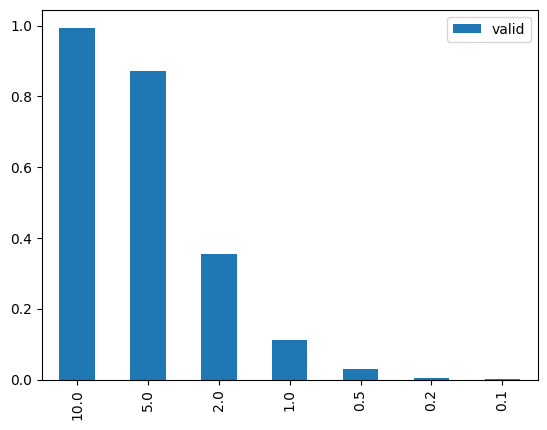

In [ ]:
legit = []
thresholds = [10, 5, 2, 1, 0.5, 0.2, 0.1]
for th in thresholds: 
    legit.append(acc[acc.apply(lambda row: abs(row.gold_lat-row.pred_lat)<th and abs(row.gold_lon-row.pred_lon)<th, 1)].shape[0]/acc.shape[0])
pd.DataFrame({"valid": legit}, index=thresholds).plot.bar();

In [ ]:
importance_pd = pd.DataFrame({"feature":linear["vect"].get_feature_names_out(), 
                              "lat": linear["reg"].coef_[0, :],
                              "lon": linear["reg"].coef_[1, :]})

* n-grams pushing north (i.e., higher lat)


In [ ]:
importance_pd.sort_values(by="lat", ascending=False).head(5)

,feature,lat,lon
30639,ταν γ,9.937351,8.255818
6660,άχ' η,9.687288,-0.013237
35250,ύλη,9.345786,0.205277
7808,ί κά,9.124316,-1.704628
17807,κά ε,9.110588,-3.502148


* n-grams pushing south (lower lat)


In [ ]:
importance_pd.sort_values(by="lat", ascending=True).head(5)

,feature,lat,lon
29194,σαν γ,-9.696831,-3.384679
34015,ω κά,-9.388093,3.309238
12339,γού κ,-8.991978,10.655044
35052,ύ κι,-8.956304,9.245348
13384,"ε, κα",-8.872916,6.376510


* n-grams pushing east (higher lon)


In [ ]:
importance_pd.sort_values(by="lon", ascending=False).head(5)

,feature,lat,lon
20365,μ που,-3.471509,17.119646
14043,εν ά,-6.841722,13.719788
11531,βκ,-4.845559,13.197189
7895,"ί, κ",2.334773,12.859669
22617,νης μ,4.918374,12.848767


* n-grams pushing west (lower lon)


In [ ]:
importance_pd.sort_values(by="lon", ascending=True).head(5)

,feature,lat,lon
5480,΄β,2.083826,-12.496209
5598,ά κρ,0.819922,-12.003664
15076,η κού,5.696004,-10.872438
16363,ι ο ν,7.556874,-10.755294
23200,ξένα,0.542027,-10.696332


# Proverb alteration

* We alread observed that duplicates exist, but near duplicates may also be present, due to spatial propagation.
* We investigate this hypothesis, by measuring the edit distance per proverb, using ones co-existing in many areas.

In [ ]:
highly_distr = duplicates.sort_values(by='area_num', ascending=False).head(3)
highly_distr

,place,place_num,area,area_num,latlon
text,,,,,
Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει,"{Δαρδανέλλια (Ελλήσποντος), Ιωάννινα, Κοζάνη, ...",45,"{Δαρδανέλλια (Ελλήσποντος), Ιωάννινα, Αρκαδία,...",23,"[(40.3376058, 26.6408207), (39.6639818, 20.852..."
Στου κουφού την πόρτα όσο θέλεις βρόντα,"{Κοζάνη, Μηλιά, Πέλλα, Γιαννιτσά, Αραβησσός, Φ...",26,"{Αρκαδία, Ιωάννινα, Φιλιππούπολη, Άνδρος, Θράκ...",20,"[(38.0368583, 23.6689264), (39.6639818, 20.852..."
"Ανεμομαζώματα, διαβολοσκορπίσματα","{Δαρδανέλλια (Ελλήσποντος), Νάξος, Απείρανθος,...",28,"{Δαρδανέλλια (Ελλήσποντος), Αρκαδία, Θράκη, Ήπ...",18,"[(40.3376058, 26.6408207), (38.0368583, 23.668..."


Measuring the edit distance between each of this and all other (non-duplicate) proverbs

In [ ]:
from Levenshtein import distance as lev
i = 0
target = highly_distr.reset_index().iloc[i].text
candidates = proverbs
candidates["lev"] = candidates.text.map(lambda x: lev(x, target))
near_duplicates = candidates[(candidates.lev<5)&((candidates.lev>0))]
near_duplicates

,text,place,uri,collector,area,lev
4879,Η γλώσσα κόκκαλα δεν έχι και κόκκαλα τσακίζ',"Θράκη, Σαράντα Εκκλησίες",http://hdl.handle.net/20.500.11853/169165,"Βαφείδης, Θεολόγης Γ.",Θράκη,3
8950,Η γλώσσα κόκκαλα δεν έχ' και κόκκαλα τσακίζει,"Μακεδονία, Βογατσικό",http://hdl.handle.net/20.500.11853/165301,"Γρέζος, Τριαντάφυλλος",Μακεδονία,2
12296,Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακά,Ρόδος,http://hdl.handle.net/20.500.11853/170697,"Δρακίδης, Γεράσιμος Δ.",Ρόδος,4
12297,Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακκά,Ρόδος,http://hdl.handle.net/20.500.11853/186599,"Δρακίδης, Γεράσιμος Δ.",Ρόδος,4
14088,Η γλώσσα κόκκαλα (δ)εν έχει και κόκκαλα τσακίζει,"Κως, Πυλί",http://hdl.handle.net/20.500.11853/179636,"Ζάρακας, Νικόλαος Α.",Κως,2
14089,Η γλώσσα κόκκαλα (δ)εν έχει και κόκκαλα τσακίζει,"Κως, Πυλί",http://hdl.handle.net/20.500.11853/195775,"Ζάρακας, Νικόλαος Α.",Κως,2
19761,Η γλώσσα κόκκαλα δεν έχει μα κόκκαλα τσακίζει,"Μακεδονία, Σισάνι, Λιμπόχοβο",http://hdl.handle.net/20.500.11853/172414,"Ιωαννίδης, Αθ.",Μακεδονία,2
28103,Η γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακεί,"Θράκη, Βιζύη",http://hdl.handle.net/20.500.11853/164735,"Ιωαννίδης, Σάββας",Θράκη,3
37378,Η γλώσσα κόκκαλα δεν έχει κόκκαλα τσακίζει,"Θράκη, Περιστερά",http://hdl.handle.net/20.500.11853/164689,"Καλλίας, Λάμπρος Γ.",Θράκη,4
54176,Γλώσσα κόκκαλα δεν έχει και κόκκαλα τσακίζει,Αδριανούπολη,http://hdl.handle.net/20.500.11853/168157,"Κουρτίδης, Κωνσταντίνος Γ.",Αδριανούπολη,3


In [ ]:
set(near_duplicates.area.values) - highly_distr.reset_index().iloc[i].area

{'Αδριανούπολη', 'Κως', 'Μακεδονία', 'Νάουσα', 'Ρόδος', 'Σκύρος'}

# Agglomerative clustering

* Besides duplicate proverbs, near-duplicates also exist, probably due to the spatial propagation of proverbs over time. 
* We employ linguistic distance to estimate the route of a proverb, assuming that shorter travels lead to fewer edits.   


```
input: proverb target, threshold e
output: the target's dendrogram
1. for proverb in proverbs:
2.   dist[proverb] = edit_distance(proverb, target)
3. sort(dist, ascending=True)
4. filtered = [p in dist if dist[p]<e] 
5. representations = TFIDF(filtered)
6. dendrogram = Ward(representations)
```

* Picking a proverb to act as our target
* Note that this can be shared across locations, or not

In [ ]:
# taken from: https://www.i-diadromi.gr/2013/09/blog-post_7104.html
target = "άλλαξε ο μανωλιός κι έβαλε τα ρούχα του αλλιώς".lower()
proverbs[(proverbs.text.str.lower().str.contains(target))]

,text,place,uri,collector,area
7875,Άλλαξε ο Μανωλιός κι έβαλε τα ρούχα του αλλιώς,"Κοζάνη, Μηλιά",http://hdl.handle.net/20.500.11853/141836,"Γιαννάκης, Γεώργιος",Κοζάνη


* Fetching proverbs up to a given linguistic distance compared to our target
* Using edit distance, we consider proverbs with few edits as candidate paraphrases of our target

In [ ]:
#!pip install python-Levenshtein
from Levenshtein import distance as lev
candidates = proverbs
candidates["lev"] = candidates.text.map(lambda x: lev(x, target))

In [ ]:
close_candidates = candidates[candidates.lev < 20]
close_candidates.sample(5)

,text,place,uri,collector,area,lev
92425,Άλλαξ' ο Κολιός κ' έβαλε την καπα αλιώς,"Ιωάννινα, Πλέσια",http://hdl.handle.net/20.500.11853/156073,"Οικονομίδης, Δημήτριος Β.",Ιωάννινα,18
118434,Άλλαξ ο Μιχαλιός κ' έβαλε τα ρουχ' αλιώς,Θράκη,http://hdl.handle.net/20.500.11853/159355,"Χρήστος, Νικόλαος",Θράκη,14
11002,Άλλαξε ο Μανωλιός κ' έβαλε τα ρουχ' αλλιώς,Μεσσηνία,http://hdl.handle.net/20.500.11853/142438,"Δουκάκης, Δημήτριος Χρ.",Μεσσηνία,9
81757,Άλλαξ ο Μανωλιός κ' έβαλε την κάππα αλλιώς,Θεσσαλία,http://hdl.handle.net/20.500.11853/154538,"Νεστορίδης, Κ.",Θεσσαλία,14
105223,Άλλαξε ο Μανωλιός κι ήβαλε τα ρούχα αλλιώς,"Κρήτη, Σητεία, Σκοπή",http://hdl.handle.net/20.500.11853/157482,"Ρουσσομουστακάκης, Νικόλαος",Κρήτη,7


* Hierarchically clustering the candidate versions of our target proverb
* Employing single linkage, using the minimum distance between the proverbs of two clusters as a criterion for merging.
* Based on the assumption that the fewer edits reflect the chosen route.  

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

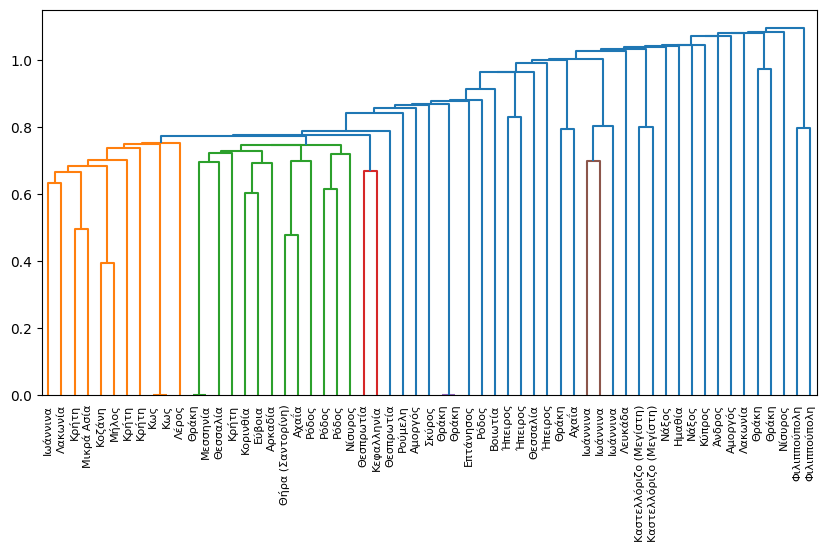

In [ ]:
vec = TfidfVectorizer(analyzer="char", ngram_range=(3,5), lowercase=True, strip_accents="unicode")
X = vec.fit_transform(close_candidates.text.values)
Z = linkage(X.toarray(), 'single')
plt.figure(figsize=(10, 5))
dendrogram(Z,
orientation='top',
           labels=close_candidates.area.values,
           distance_sort='descending',
           show_leaf_counts=False,
           leaf_font_size=8.,
           show_contracted=True,
          ); plt.show();

* To better understand the clustering, we create a dataframe and filter based on distance

In [ ]:
clustering = fcluster(Z, t=0.7, criterion='distance')
close_candidates.insert(7, "clustering", clustering)
#close_candidates["clustering"] = clustering
grouped = close_candidates.groupby("clustering")
clusters = pd.DataFrame({"cluster":grouped.area.apply(list), "text":grouped.text.apply(list)})
clusters[clusters.cluster.apply(len)>1]

,cluster,text
clustering,,
7,"[Ιωάννινα, Ιωάννινα]","[Άλλαξ' ο Κολιός κ' έβαλε την καπα αλιώς, Άλλα..."
13,"[Θράκη, Θράκη]","[Άλλαξ ο Μιχαλιός κ' έβαλε τα ρουχ' αλιώς, Άλλ..."
14,"[Κεφαλληνία, Θεσπρωτία]","[Άλλαξ' ο Μανωλιός κι' έβαλε τα ρούχ' αλλιώς, ..."
15,"[Ρόδος, Ρόδος]",[Έλλαξεν ο Μανωλιός κι' έβαλεν τα ρούχα αλλοιώ...
17,"[Ρόδος, Αχαΐα, Θήρα (Σαντορίνη)]","[Έλλαξεν ο Μανωλιός κ' έβαλεν τα ρουχ' αλλιώς,..."
18,"[Εύβοια, Αρκαδία, Κορινθία]","[Άλλαξε ο Μανωλιός κι' έβαλε τα ρούχ' αλλοιώς,..."
19,"[Μεσσηνία, Θεσσαλία, Θράκη]","[Άλλαξε ο Μανωλιός κ' έβαλε τα ρουχ' αλλιώς, Α..."
21,"[Κως, Κως]",[Άλλαξεν ο Μανωλιός κι ήβαλεν τα ρούχα του αλλ...
22,"[Μήλος, Κοζάνη, Λακωνία, Μικρά Ασία, Ιωάννινα,...",[Άλλαξε ο Μανωλιός κι έβαλε τα ρούχα του αλλοι...


In [ ]:
# focus on clusters with more than one area
for i, row in clusters[clusters.cluster.apply(len)>1].iterrows():
    # hash to avoid duplicated areas (neighbouring proverbs)
    d = dict(list(zip(row.cluster, row.text)))
    if len(d)>1: # ignore duplicates
        # print the clustered versions  
        for place in d:
            print(f'{place} --> {d[place]}')
        print()

Κεφαλληνία --> Άλλαξ' ο Μανωλιός κι' έβαλε τα ρούχ' αλλιώς
Θεσπρωτία --> Άλλαξ' ο κολιός κι' έβαλε τα ρουχ' αλλιώς

Ρόδος --> Έλλαξεν ο Μανωλιός κ' έβαλεν τα ρουχ' αλλιώς
Αχαΐα --> Άλλαξεν ο Μανωλιός κ' ήβαλεν τα ρουχ' αλλοιώς
Θήρα (Σαντορίνη) --> Ήλλαξεν ο Μανωλιός κ' ήβαλεν τα ρουχ' αλλιώς

Εύβοια --> Άλλαξε ο Μανωλιός κι' έβαλε τα ρούχ' αλλοιώς
Αρκαδία --> Άλλαξε ο Μανωλιός κι' έβαλε τα ρουχ' αλλεώς
Κορινθία --> Άλλαξε ο Μανωλιός κι' έβαλλε τα ρουχ' αλλοιώς

Μεσσηνία --> Άλλαξε ο Μανωλιός κ' έβαλε τα ρουχ' αλλιώς
Θεσσαλία --> Αλλαξ ο Μανωλιός κ' έβαλε τα ρουχ' αλλιώς
Θράκη --> Άλλαξε ο Μανωλιός κ' έβαλε τα ρουχ' αλλιώς

Μήλος --> Άλλαξε ο Μανωλιός κι έβαλε τα ρούχα του αλλοιώς
Κοζάνη --> Άλλαξε ο Μανωλιός κι έβαλε τα ρούχα του αλλιώς
Λακωνία --> Άλλαξε ο Μανωλιός κι έβαλε τα ρούχα αλλιώς
Μικρά Ασία --> Άλλαξεν ο Μανωλιός κι ήβαλε τα ρούχα αλλιώς
Ιωάννινα --> Άλλαξε ο Μανωλιός κι έβαέ τα ρούχα αλλιώς
Κρήτη --> Άλλαξε ο Μανωλιός κι ήβαλε τα ρούχα αλλιώς

